In [8]:
competition_name = "paddy-disease-classification"

In [9]:
!pip install mlflow --quiet
!pip install pyngrok --quiet


Read the MLFlow authentication tokens from colab secrets

In [10]:
import mlflow, os
from pyngrok import ngrok
if os.getenv("COLAB_RELEASE_TAG"):
    from google.colab import userdata
    os.environ['MLFLOW_TRACKING_USERNAME'] = userdata.get('MLFLOW_TRACKING_USERNAME')
    os.environ['MLFLOW_TRACKING_PASSWORD'] = userdata.get('MLFLOW_TRACKING_PASSWORD')
else:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    os.environ['MLFLOW_TRACKING_USERNAME'] = user_secrets.get_secret("MLFLOW_TRACKING_USERNAME")
    os.environ['MLFLOW_TRACKING_PASSWORD'] = user_secrets.get_secret("MLFLOW_TRACKING_USERNAME")
os.environ['MLFLOW_TRACKING_PROJECTNAME'] = 'PADDYDOCTOR'

Start the MLFlow service in background on port 5000 for run logging in MLFlow

In [11]:
# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &")# run tracking UI in the background

In [12]:
# mlflow.set_tracking_uri('http://localhost:5000')

Using ngrok connect MLFLow local service URL to internet

In [17]:
!ngrok config check

Valid configuration file at /root/.config/ngrok/ngrok.yml


In [21]:
# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
if os.getenv("COLAB_RELEASE_TAG"):
    NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
else:
    NGROK_AUTH_TOKEN = user_secrets.get_secret("NGROK_AUTH_TOKEN")
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Check if a tunnel is already running before starting a new one
active_tunnels = ngrok.get_tunnels()
active_tunnels
if not active_tunnels:
    # Open an HTTPs tunnel on port 5000 for http://localhost:5000
    public_url = ngrok.connect(5000, name='MLFLow URL')
    print("MLflow Tracking UI:", public_url)
else:
    print("An ngrok tunnel is already running:", active_tunnels[0].public_url)
    public_url = active_tunnels[0].public_url # Use the existing tunnel's URL

MLflow Tracking UI: NgrokTunnel: "https://e4e0-34-81-188-53.ngrok-free.app" -> "http://localhost:5000"


Invoke cleanup at the end to stop MLFlow logging

In [22]:
# Cleanup function
def cleanup():
    # Close MLflow run if any is active
    try:
        mlflow.end_run()
    except:
        pass

    # Disconnect ngrok
    try:
        ngrok.disconnect(listener.url())
        ngrok.kill()  # Kill the ngrok process
    except:
        pass

    # Kill MLflow server (optional, if you want to completely shut down the server)
    !pkill -f "mlflow server"

In [23]:
# Register cleanup to run at exit
# atexit.register(cleanup)

In [24]:
# Create a new experiment
try:
    experiment = mlflow.create_experiment('test1')
except mlflow.exceptions.MlflowException as e:
    # If experiment already exists, get its ID
    experiment = mlflow.get_experiment_by_name('test1').experiment_id

# Set the experiment
mlflow.set_experiment('test1')

<Experiment: artifact_location='file:///content/mlruns/502100341309366732', creation_time=1730092135585, experiment_id='502100341309366732', last_update_time=1730092135585, lifecycle_stage='active', name='test1', tags={}>

A trial parameter logging on MLFlow

In [25]:
# with mlflow.start_run(run_name="MLflow on Colab"):
#   mlflow.log_metric("m1", 2.0)
# mlflow.log_artifact(confusion_matrix_file_name)
mlflow.log_param('competition', competition_name)

'paddy-disease-classification'

In [26]:
# os.environ.get('MLFLOW_TRACKING_USERNAME')

In [27]:
import os
if os.getenv("COLAB_RELEASE_TAG"):
   print("Running in Colab")
else:
   print("NOT in Colab")

Running in Colab


If notebook on colab, grant access to my google drive and access from notebook

In [28]:

# Mount your Google Drive.
import os
if os.getenv("COLAB_RELEASE_TAG"):
  file_path = "/content/drive"
  if not os.path.exists(file_path):
    from google.colab import drive
    drive.mount("/content/drive")

Mounted at /content/drive


In [29]:
! pip install kaggle --quiet

If notebook on colab copy my kaggle token from my google drive to .kaggle directory to authenticate with kaggle for data dowload and notebook upload to kaggle.

In [30]:
if os.getenv("COLAB_RELEASE_TAG"):
  file_path = "~/.kaggle/kaggle.json"
  if not os.path.exists(file_path):
    kaggle_creds_path = "/content/drive/MyDrive/kaggle.json"
    ! mkdir ~/.kaggle
    ! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json

In [31]:
!pip install fastkaggle --quiet

In [32]:
from fastai.vision.all import *
from fastkaggle import *  # for easy Kaggle dataset access

If notebook on colab download the dataset from kaggle if the dataset is not already present in my google drive.

In [33]:
# Set up Kaggle credentials (you'll need to provide your kaggle.json file)
if os.getenv("COLAB_RELEASE_TAG"):
  save_data_drive_path='/content/drive/MyDrive/paddy-disease-classification'
  if not os.path.exists(save_data_drive_path):
    file_path = "/content/paddy-disease-classification.zip"
    if not os.path.exists(file_path):
      setup_comp('paddy-disease-classification', 'train.csv')
  else:
    print("Data already downloaded and saved in drive")

Data already downloaded and saved in drive


If notebook on colab download the dataset from kaggle if the dataset is not already present in my google drive and copy to my google drive.

In [34]:
if os.getenv("COLAB_RELEASE_TAG"):
  import zipfile
  if not os.path.exists(save_data_drive_path):
    os.mkdir(save_data_drive_path)
  dir = os.listdir(save_data_drive_path)
  if len(dir) == 0:
    with zipfile.ZipFile('paddy-disease-classification.zip', 'r') as zip_ref:
      zip_ref.extractall(save_data_drive_path)

check if the notebook is running in GPU or CPU and use this variable to change the training methods according to the processor.

In [35]:
# Check available device and set defaults
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
import fastai.torch_core
if device == 'cpu':
    fastai.torch_core.default_device(use=False)

Using device: cpu


In [36]:
# import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['PYTORCH_CUDA_ALLOC_CONF']='expandable_segments'

If google colab notebook set the input paths accordingly, otherwise set the input paths according to kaggle paths.

In [37]:
# Set paths
if os.getenv("COLAB_RELEASE_TAG"):
  path = Path(save_data_drive_path)
  train_path = path/'train_images'
  test_path = path/'test_images'
else:
    path = Path('../input/paddy-disease-classification')
    train_path = path/'train_images'
    test_path = path/'test_images'
print(f"Train path: {train_path}")  # Print the train path
print(f"Test path: {test_path}")   # Print the test path

Train path: /content/drive/MyDrive/paddy-disease-classification/train_images
Test path: /content/drive/MyDrive/paddy-disease-classification/test_images


Instead of the get_image_files which will load all the images into the DataBlock for training created a custom function get_subset_items. Will use this loader function during the initial trial runs to quick perform training with a smaller dataset to verify the code and then switch back to get_image_files for the final run. Ensure that the subset is not too small, there is a risk some labels are not included and training will fail. Additional steps can be added within the get_subset_items to get a more equitable sampling of images.

In [38]:
def get_subset_items(path):
    files = get_image_files(path)
    sample_size=500
    print(f'{sample_size } images out of {len(files)}', )
    return L(files).shuffle()[:sample_size]

item_tfms are applied inidividually on each image. batch_tfms are applied to the whole batch of images. These two data augmentation steps are passed to the DataBlock to apply on the data defined in the DataBlock.

In [39]:
# Enhanced data augmentation pipeline
item_tfms = [
    RandomResizedCrop(460, min_scale=0.75),  # Randomly crop and resize
    FlipItem(p=0.5),  # Horizontal flip with 50% probability
]

batch_tfms = [
    *aug_transforms(
        size=224,
        max_rotate=10.0,  # Rotation up to 10 degrees
        max_zoom=1.1,     # Zoom in up to 10%
        max_lighting=0.2, # Adjust brightness
        max_warp=0.2,    # Perspective warping
        p_affine=0.75,   # Probability of applying affine transforms
        p_lighting=0.75,  # Probability of applying lighting transforms
    ),
    Normalize.from_stats(*imagenet_stats),
    RandomErasing(p=0.5, max_count=2)  # Random erasing for occlusion robustness
]

# Create DataBlock with augmentations
paddy_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_subset_items,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms
)

My Google drive path to save the model

In [40]:
if os.getenv("COLAB_RELEASE_TAG"):
  model_path='/content/drive/MyDrive/paddy-disease-classification/models/'

In [41]:
tta_res = []

Just to view a batch of images

500 images out of 10407


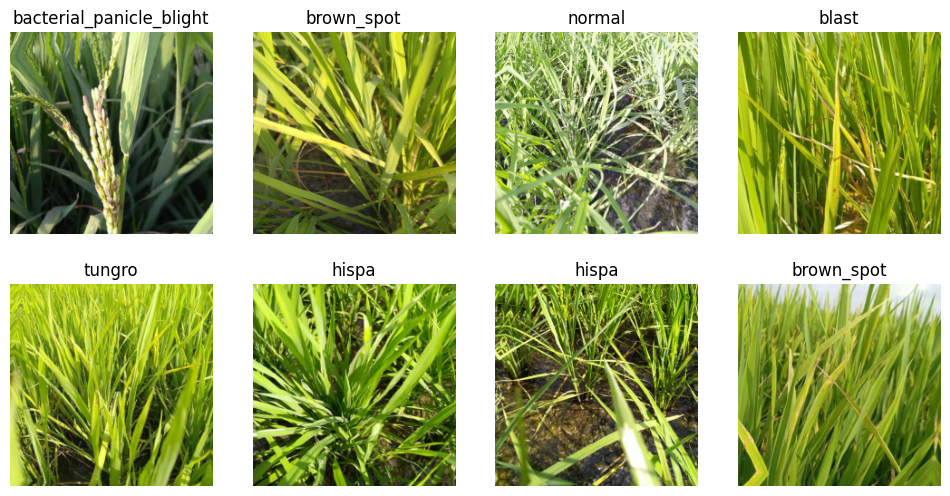

In [42]:
kwargs = { 'bs': 16 }
dls = paddy_block.dataloaders(train_path, **kwargs)
dls.show_batch(max_n=8)

Defined a training method,

*   Set the batch size with bs parameter
*   Use the DataBlock defined above for data loading
*   Use gradient accumulator after every 2 epochs ??



In [43]:
def train(desc,arch,item,batch,accum=False):
  kwargs = { 'bs': 16 } if accum else {}
  dls = paddy_block.dataloaders(train_path, **kwargs)
  cbs = GradientAccumulation(2) if accum else []
  learn = vision_learner(dls, arch, metrics=error_rate,cbs=cbs).to_fp16()
  learn.fine_tune(5,0.01)
  tta_res.append(learn.tta(dl=dls.test_dl(test_path.ls())))
  learn.export(f'{arch}_{desc}.pkl')
  os.system(f'cp {arch}_{desc}.pkl {model_path}/{arch}_{desc}.pkl')
  return learn

Initiate training for the resnet26d archicture pretrained model

In [ ]:
arch='resnet26d'
learn = train('squish',arch,item=Resize(480,method='squish'),batch=aug_transforms(size=224,min_scale=0.75))
learn.show_results()

500 images out of 10407


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,3.468040,4.621719,0.710000,05:18


epoch,train_loss,valid_loss,error_rate,time
0,2.170684,2.100524,0.560000,04:58
1,1.792192,1.902260,0.520000,04:51


Initiate the training for the convnext_tiny pretrained model architecture

In [ ]:
arch='convnext_tiny'
learn = train('squish',arch,item=Resize(480,method='squish'),batch=aug_transforms(size=224,min_scale=0.75))
learn.show_results()

In [ ]:
tta_res[:3]

In [ ]:
# # Create DataLoaders
# dls = paddy_block.dataloaders(train_path, bs=200)

In [ ]:
# # Run this in a separate cell
# # keep_alive()

# # Create learner
# learn = vision_learner(dls, 'resnet26d', metrics=error_rate).to_fp16()

# # Train with one cycle policy
# learn.fine_tune(5, 3e-3)

# # Save the model
# learn.save('paddy_model')

In [ ]:
# learn.show_results()

In [ ]:
# # Create test DataLoader
# test_files = get_image_files(test_path)
# test_files.sort()
# test_dl = learn.dls.test_dl(test_files, with_labels=False, bs=200)

In [ ]:
# probs,_,idxs = learn.get_preds(dl=test_dl, with_decoded=True)

In [ ]:
# mapping = dict(enumerate(dls.vocab))
# results = pd.Series(idxs.numpy(), name="idxs").map(mapping)

In [ ]:
# ss = pd.read_csv(path/'sample_submission.csv')
# ss['label'] = results
# ss.to_csv('submission.csv', index=False)
# !head submission.csv

In [ ]:
# if not iskaggle:
#     from kaggle import api
#     api.competition_submit_cli('submission.csv', 'initial rn26d 128px', competition_name)

In [ ]:
# if not iskaggle:
#     push_notebook('pkappaka3', 'paddydoctor_multimodel_v1',
#     title='paddy_doctor_multimodel_v3',
#     file='/content/drive/MyDrive/Colab Notebooks/paddydoctor_multimodel.ipynb' ,
#     competition=competition_name, private=False, gpu=True)

In [ ]:
# Or call cleanup manually when you're done
cleanup()